In [ ]:
# include("../finite_difference.jl")
# include("../ode_solver.jl")

# kappa = 1   # diffusion constant
# L = 1.0         # length of spatial domain
# T = 0.5         # total time to solve for

# function u_I(x)
#     # initial temperature distribution
#     y = sin.(pi*x/L)
#     return y
# end

# function u_exact(x,t)
#     # the exact solution
#     y = exp.(-kappa*(pi^2/L^2)*t)*sin.(pi*x/L)
#     return y
# end

# # Set numerical parameters
# mx = 10     # number of gridpoints in space
# mt = 1000   # number of gridpoints in time


# # forward euler Estimate
# weird_x, u_j = finite_difference(u_I, kappa, L, T, mx, mt, forward_euler)
# # Create trace
# f_euler = scatter(x=x, y=u_j, mode="markers", name="forward euler", showlegend=true)


# # backward euler Estimate
# x, u_j = finite_difference(u_I, kappa, L, T, mx, mt, backward_euler)
# # Create trace
# b_euler = scatter(x=x, y=u_j, mode="markers", name="backward euler", showlegend=true)


# # crank nicholson Estimate
# x, u_j = finite_difference(u_I, kappa, L, T, mx, mt, crank_nicholson)
# # Create trace
# c_nicholson = scatter(x=x, y=u_j, mode="markers", name="crank nicholson", showlegend=true)



# # Plot the final result and exact solution
# xx = LinRange(0,L,250)

# # Create solution trace
# exact = scatter(x=xx, y=u_exact(xx,T), mode="lines", name="exact", showlegend=true)

# layout = Layout(
#     xaxis_title = "x",
#     yaxis_title = "u(x,0.5)"
#     )

# plot([exact, f_euler, b_euler, c_nicholson], layout)

In [21]:
using PlotlyJS
using Test
include("../ode_solver.jl")
include("../numerical_shooting.jl")
include("../examples/example_functions.jl")
include("../visualisation.jl")
include("../finite_difference.jl")

crank_nicholson (generic function with 1 method)

In [47]:
@testset verbose = true "System Unit Tests" begin

    @testset verbose = true "ode_solver" begin

        @testset verbose = true "Input Tests" begin

            # test error is thrown if t=0 is not included in t
            t = 0:0.1:1
            bad_t = 1:0.1:2
            @test_throws ErrorException solve_ode(f2, [1], bad_t, method="rk4")


            # test error is thrown if x0 is not a matrix
            @test_throws ErrorException solve_ode(f2, 1, t, method="rk4")
            @test_throws ErrorException solve_ode(f2, [1;0], t, method="rk4")
            @test_throws ErrorException solve_ode(f2, [1, 0], t, method="rk4")

        
            # test error is thrown if x0 is not a 1xn matrix
            @test_throws ErrorException solve_ode(f2, [1 2; 3 4], t, method="rk4")


            # test error is thrown if x0 is not correct length
            @test_throws ErrorException solve_ode(f2, [1], t, method="rk4")

        end

        @testset verbose = true "Output Tests" begin

            # test if solve_ode estimates a simple ODE correctly
            x0 = [1]
            t = 0:1
            e_estimate = solve_ode(f, x0, t, method="rk4")[end][1]
            @test isapprox(e_estimate, ℯ)


            # test if solve_ode estimates systems of ODEs correctly
            x0 = [1 0]
            t = 0:0.1:1
            f2_sol = f2_solution(x0, t)
            f2_numerical_sol = solve_ode(f2, x0, t, method="rk4")
            @test  all(isapprox.(f2_numerical_sol, f2_sol, atol=1e-6))

        end
    end

    @testset verbose = true "numerical_shooting" begin

        @testset verbose = true "Input Tests" begin

            # test error is thrown if T is not an integer or float
            T = 10
            bad_T = 1:0.1:2
            @test_throws ErrorException find_limit_cycle(f2, [1], bad_T)
        
        
            # test error is thrown if u0 is not a matrix
            @test_throws ErrorException find_limit_cycle(f2, 1, T)
            @test_throws ErrorException find_limit_cycle(f2, [1;0], T)
            @test_throws ErrorException find_limit_cycle(f2, [1, 0], T)
        
        
            # test error is thrown if u0 is not a 1xn matrix
            @test_throws ErrorException find_limit_cycle(f2, [1 2; 3 4], T)
        
        
            # test error is thrown if u0 is not correct length
            @test_throws ErrorException find_limit_cycle(f2, [1], 10)
        
        
            # test error is thrown if phase_index is a positive integer
            @test_throws ErrorException find_limit_cycle(f2, [1 1], 10, phase_index=-1)
            @test_throws ErrorException find_limit_cycle(f2, [1 1], 10, phase_index=[3])
            @test_throws ErrorException find_limit_cycle(f2, [1 1], 10, phase_index=2.5)
            @test_throws ErrorException find_limit_cycle(f2, [1 1], 10, phase_index="0")
        
        end

        @testset verbose = true "Output Tests" begin

            # test if found limit cycle matches the analytical solution
            u0, T = find_limit_cycle(hopf2d, [-1 0], 6)
            @test isapprox(T, 2*pi)


            # test if solve_ode estimates a Hopf ODE correctly
            t = 0:0.1:T
            hopf_solution = hopf2d_sol(t, beta=1, theta=pi) # adjusted for phase
            hopf_numerical_sol = solve_ode(hopf2d, u0, t, method="rk4")
            @test  all(isapprox.(hopf_numerical_sol, hopf_solution, atol=1e-6))


            # test if arguments are being passed to the function correctly
            u0_0, T = find_limit_cycle(hopf2d, [-1 0], 6)
            u0_1, T = find_limit_cycle(hopf2d, [-1 0], 6, beta = 2)
            u0_3, T = find_limit_cycle(hopf2d, [-1 0], 6, beta = 2, sigma=-1.2)
            u0_2, T = find_limit_cycle(hopf2d, [-1 0], 6, sigma=-1.2)
            @test u0_0 != u0_1
            @test u0_0 != u0_2
            @test u0_0 != u0_3

        end

        @testset verbose = true "Higher Dimensional Output" begin

            # test if found limit cycle matches the analytical solution
            u0, T = find_limit_cycle(hopf3d, [1 1 1], 6)
            @test isapprox(T, 2*pi)


            u0, T = find_limit_cycle(hopf3d, [1 1 1], 10)
            hopf_solution = hopf3d_sol(u0, 0:0.1:T; theta=0) # adjusted for phase
            hopf_numerical_sol = solve_ode(hopf3d, u0, 0:0.1:T, method="rk4")
            @test all(isapprox.(hopf_numerical_sol, hopf_solution, atol=1e-5))
            

        end
    end

    @testset verbose = true "finite_difference" begin

        @testset verbose = true "Input Tests" begin

            # test error is thrown if t=0 is not included in t
            t = 0:0.1:1
            bad_t = 1:0.1:2
            @test_throws ErrorException solve_ode(f2, [1], bad_t, method="rk4")

        end

        @testset verbose = true "Output Tests" begin
            
            # test if found limit cycle matches the analytical solution
            u0, T = find_limit_cycle(hopf2d, [-1 0], 6)
            @test isapprox(T, 2*pi)

        end
    end
end



Test Summary:                 | Pass  Total
Systems Tests                 |   27     27
  ode_solver                  |    8      8
    Input Tests               |    6      6
    Output Tests              |    2      2
  numerical_shooting          |   17     17
    Input Tests               |   10     10
    Output Tests              |    5      5
    Higher Dimensional Output |    2      2
  finite_difference           |    2      2
    Input Tests               |    1      1
    Output Tests              |    1      1


Test.DefaultTestSet("Systems Tests", Any[Test.DefaultTestSet("ode_solver", Any[Test.DefaultTestSet("Input Tests", Any[], 6, false, true), Test.DefaultTestSet("Output Tests", Any[], 2, false, true)], 0, false, true), Test.DefaultTestSet("numerical_shooting", Any[Test.DefaultTestSet("Input Tests", Any[], 10, false, true), Test.DefaultTestSet("Output Tests", Any[], 5, false, true), Test.DefaultTestSet("Higher Dimensional Output", Any[], 2, false, true)], 0, false, true), Test.DefaultTestSet("finite_difference", Any[Test.DefaultTestSet("Input Tests", Any[], 1, false, true), Test.DefaultTestSet("Output Tests", Any[], 1, false, true)], 0, false, true)], 0, false, true)

In [44]:

@testset verbose = true "Input Tests" begin

    # test error is thrown if T is not an integer or float
    T = 10
    bad_T = 1:0.1:2
    @test_throws ErrorException find_limit_cycle(f2, [1], bad_T)


    # test error is thrown if u0 is not a matrix
    @test_throws ErrorException find_limit_cycle(f2, 1, T)
    @test_throws ErrorException find_limit_cycle(f2, [1;0], T)
    @test_throws ErrorException find_limit_cycle(f2, [1, 0], T)


    # test error is thrown if u0 is not a 1xn matrix
    @test_throws ErrorException find_limit_cycle(f2, [1 2; 3 4], T)


    # test error is thrown if u0 is not correct length
    @test_throws ErrorException find_limit_cycle(f2, [1], 10)


    # test error is thrown if phase_index is a positive integer
    @test_throws ErrorException find_limit_cycle(f2, [1 1], 10, phase_index=-1)
    @test_throws ErrorException find_limit_cycle(f2, [1 1], 10, phase_index=[3])
    @test_throws ErrorException find_limit_cycle(f2, [1 1], 10, phase_index=2.5)
    @test_throws ErrorException find_limit_cycle(f2, [1 1], 10, phase_index="0")

end

Test Summary: | Pass  Total
Input Tests   |   10     10


Test.DefaultTestSet("Input Tests", Any[], 10, false, true)

In [46]:
include("../numerical_shooting.jl")


([-1.8626078457373296e-10 -3.9475089863572066e-12], 10.000000000290742)

In [73]:
[1.5213797068045676 1.5213797068045676; 1.5196950998336984 1.5196950998336984 ; 0.577350268222558 0.577350268222558; 0.577350268222558 0.577350268222558]

4×2 Matrix{Float64}:
 1.52138  1.52138
 1.5197   1.5197
 0.57735  0.57735
 0.57735  0.57735

u0: [-1.152939965720634e-9 -3.9475089863572066e-12]
Period: 6.000000000112355


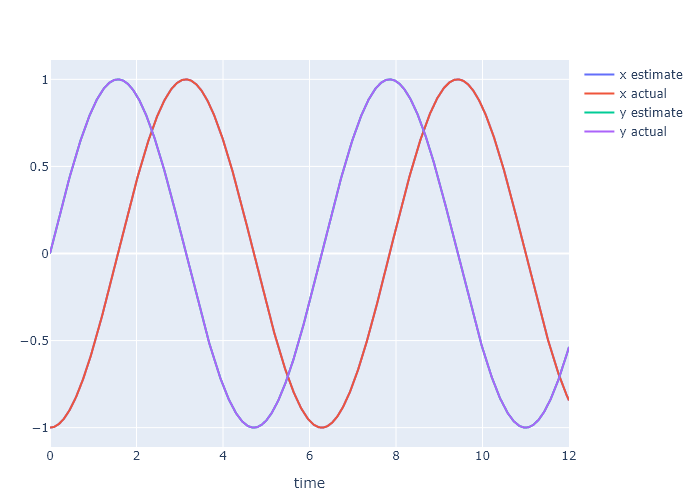

In [226]:
include("../examples/example_functions.jl")

t = 0:0.01:10
x0 = [1 1]



u0, T = find_limit_cycle(f2, x0, 6)
println("u0: ", u0)
println("Period: ", T)

t = 0:0.01:2*T
x0 = [-1 0]


hopf_solution = f2_solution(x0,t) # adjusted for phase
hopf_numerical_sol = solve_ode(f2, x0, t, method="rk4", Δt=0.01)


# Create traces
x_est = scatter(x=t, y=hopf_numerical_sol[:,1], mode="lines", name="x estimate", showlegend=true)
x_act = scatter(x=t, y=hopf_solution[:,1], mode="lines", name="x actual", showlegend=true)
y_est = scatter(x=t, y=hopf_numerical_sol[:,2], mode="lines", name="y estimate", showlegend=true)
y_act = scatter(x=t, y=hopf_solution[:,2], mode="lines", name="y actual", showlegend=true)


layout = Layout(
    xaxis_title = "time",
    width=700, height=350,
    )

plot([
    x_est,x_act,
    y_est,y_act,
    # z_est,z_act
], layout)

In [65]:
found_x0 = [0 0 6]

conditions = [1 2 3]
conditions = [conditions; found_x0]

2×3 Matrix{Int64}:
 1  2  3
 0  0  6

In [70]:
conditions[[end],:]

1-element Vector{Int64}:
 6

In [63]:
par_values = LinRange(0,2,21)
par_values[2:end]

20-element LinRange{Float64, Int64}:
 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,…,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0

In [58]:
tr = 0.0:0.1:2.0
for t in tr 
    print(t,",")
end

0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,